<a href="https://colab.research.google.com/github/asgutierrt/Introduction-to-IA/blob/main/neural_networks/autoencoder_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron

In [14]:
# requirements
import os
import numpy as np
#from sympy import *
import pandas as pd

# visualization
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# data handling
import time
import copy
import json

## auxiliary functions

In [2]:
################## support functions
def process_exp (model_label,model,local_grads,avrg_error,grad_dead_at,n,m,L,start,X_test,Y_d_test,dfs,csv_path):
  ''' Process and store local gradients and error data of model. Appends the information onto dfs.
  args:
      model: MLP class object
      model_label: model identifier
      local_grads: list of local grads for each neuron per training iteration
      avrg_error: error that backpropegates on each iteration
      grad_dead_at: iteration at which the gradient changes fell bellow tolerance level
  '''
  # unpack storage dfs
  predictions,w_vals,energia_error,error,deltas,avrg_delta = dfs

  # store weights after training
  for layer,ws in model.w_dict.items(): w_vals.at[model_label,layer]=str(ws.tolist())
  w_vals.to_csv(csv_path+"/w_vals.csv")

  # error energy
  df_error=pd.DataFrame(avrg_error,columns=pd.MultiIndex.from_tuples([('error',)+model_label]),dtype=float)
  energia_error=pd.concat([energia_error,df_error], axis=1)
  energia_error.to_csv(csv_path+"/energia_errores.csv")

  # training error
  error.loc[model_label,'train error']=df_error.mean().values[0]

  # test error
  model.frwd_eval(model.w_dict,X_test.T)
  Y_pred=model.Y
  test_errors=np.mean(np.apply_along_axis(lambda x: np.matmul(x,x)/2, 1, Y_d_test-Y_pred.T))

  # prediction of test input dataset
  Y_pred_dict=dict(zip(range(m),model.Y))
  for output,y_pred in Y_pred_dict.items(): predictions.at[model_label,output]=str(y_pred.tolist())
  predictions.to_csv(csv_path+"/predictions.csv")
  error.loc[model_label,'test error']=test_errors

  # execution time
  error.loc[model_label,'time [s]']=time.time()-start

  # local gradients
  cols_label=lambda layer, neurons: pd.MultiIndex.from_tuples([("$\\delta_%s$"%layer,)+model_label+('neuron %i'%i,) for i in neurons])
  info_delta=lambda grad_info,layer: pd.DataFrame(grad_info,dtype=float,columns=cols_label(layer,range(len(grad_info[0]))))
  df_local_grads=pd.concat([info_delta(local_grads[layer],layer) for layer in pd.DataFrame(local_grads)],axis=1)
  #deltas[df_local_grads.columns]=df_local_grads
  #deltas.to_csv(csv_path+"/deltas.csv")

  # mean local gradients
  df_mean=df_local_grads.groupby(level=[0,1,2,3],axis=1).mean()
  avrg_delta[df_mean.columns]=df_mean
  avrg_delta.to_csv(csv_path+"/avrg_deltas.csv")

  # estabilization values
  df_stable_mean=df_local_grads.iloc[grad_dead_at:].groupby(level=[0],axis=1).mean()
  error.loc[model_label,df_stable_mean.columns]=df_stable_mean.mean(axis=0)[df_stable_mean.columns]
  error.loc[model_label,'gradient death i']=grad_dead_at
  error.to_csv(csv_path+"/errores_train_test.csv")

  return predictions,w_vals,energia_error,error,deltas,avrg_delta

def graficar_df(df,layout,y_label,x_label,title,rot=0,figsize=(7,4),name='',path=''):
  '''creates one figure for each item of df at level 0'''

  # subfigures names
  dim_names=set(df.columns.get_level_values(0))

  # define horizontal or vertical layout
  fig_x,fig_y= (1,len(dim_names)) if layout=="h" else (len(dim_names),1)

  # init figure
  fig, ax = plt.subplots(fig_x,fig_y,figsize=figsize,sharex=True,squeeze=False)
  labels=None
  for i, (dimension, df_) in enumerate(df.groupby(level=0,axis=1)):
    ix,iy= (0,i) if layout=="h" else (i,0)
    labels_i=df_[dimension].columns.tolist()
    df_.plot(ax=ax[ix,iy],style=[".-"]*len(labels_i),rot=rot,legend=False)
    ax[ix,iy].set_ylabel(y_label(i))
    ax[ix,iy].set_xlabel(x_label)
    if labels is None: labels=labels_i

  # set up legend and titles
  fig.suptitle(title,y=1)
  fig.legend(labels,bbox_to_anchor=[0.5, 0.97],loc='upper center',ncol=12,fontsize="small",alignment='left')
  fig.tight_layout(); plt.savefig(path+'/%s.png'%name)

def graficar_Y(Y,predictions,figs,model_names,title,fig_path):

    # init figure
    fig = plt.figure(figsize=(8,5))

    # consistent colors for each output dimension
    max_m=3
    cmap = plt.get_cmap('rainbow', max_m)
    style_list=["--",":","-."]

    # plot Y and all predictions (Id given by model_names)
    plt.plot(Y)
    for i, name in enumerate(model_names):
        plt.gca().set_prop_cycle(None)
        Y_pred=np.array([json.loads(y_pred) for output,y_pred in predictions.loc[name].items()])
        plt.plot(Y_pred.T,linestyle=style_list[i])

    # set up legends and titles
    legend=['Y%i'%i for i in range(Y.shape[1])]+["Y%i: "%i+model+" "+str(name) for model,name in zip(figs,model_names) for i in range(Y.shape[1])]
    fig.legend(legend,bbox_to_anchor=[0.98, 0.899],loc='upper right')
    fig.suptitle(title)
    fig.tight_layout()
    plt.savefig(fig_path)

def load_data(data_path,fig_path=False,autoencoder=False):

    # open data_path file
    File_data = pd.read_csv(data_path, sep=",", header=None)

    # normalize [-1,1]
    File_data = 2*(File_data/np.max(File_data,axis=0))-1

    # uniform random sample: 60% training, 20% test, 20% validation
    n_data, n_dim = File_data.shape
    ix = np.random.choice(n_data, n_data, replace=False)
    n_train=int(n_data*0.6); n_test=int(n_data*0.2); n_val=int(n_data*0.2)

    # sort data into datasets
    ## autoencoder: input=output variables
    col_x,col_y=([0,1,2],[3,4]) if not autoencoder else ([0,1,2],[0,1,2])

    data_train=File_data[set(col_x+col_y)].loc[ix[:n_train]]
    data_test=File_data[set(col_x+col_y)].loc[ix[n_train:n_train+n_test]].sort_index()
    data_val=File_data[set(col_x+col_y)].loc[ix[-n_val:]].sort_index()

    # split datasets: input and output
    X = data_train[col_x].to_numpy(); Y_d = data_train[col_y].to_numpy()
    X_test=data_test[col_x].to_numpy(); Y_d_test = data_test[col_y].to_numpy()
    X_val=data_val[col_x].to_numpy(); Y_d_val = data_val[col_y].to_numpy()

    # plot data: color each dataset
    fig, ax=plt.subplots(figsize=(12,5))
    data_train.sort_index().plot(style='.',markersize=0.5,color='y',ax=ax)
    data_test.plot(style='.',markersize=0.5,color='g',ax=ax)
    data_val.plot(style='.',markersize=0.5,color='r',ax=ax)

    # annotate input/output variables
    if not autoencoder:
      vars=[("x%i"%x,x) for x in col_x]+[("y%i"%(y-len(col_x)),y) for y in col_y]
    else:
      vars=[("x%i/y%i"%(x,x),x) for x in col_x]
    annotate=data_test.iloc[-1]
    for x,ix in vars: ax.annotate(x,(annotate.name,annotate[ix]))

    # set up legends and titles
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::int(len(labels)/n_dim)], ['train','test','validation'])
    plt.savefig(fig_path+'/data.png')
    return X,Y_d,X_test,Y_d_test,X_val,Y_d_val

## MLP classes

In [3]:
class MLP:
  # class attributes
  __slots__ = ['conf','w_dict','Y']

  def __init__(self,layers_setup,entrada,bias):
    self.conf={}; self.w_dict={};
    for layer,(neuronas,phi,diff_phi) in enumerate(layers_setup):
      # store a layer on each item of conf
      self.conf[layer]=layer_obj(entrada,neuronas,phi,diff_phi,bias[layer])

      # next layer input is current output
      entrada=self.conf[layer].Y

      # store random initial w values
      self.w_dict[layer]=self.conf[layer].W

    # final model output
    self.Y=entrada

  def frwd_eval(self,w_dict,entrada):
    # evaluate each layer on given weights and input vectors
    for layer in range(len(self.conf)):
      self.conf[layer].update_w(w_dict[layer],entrada)
      entrada=self.conf[layer].Y
    self.Y=entrada

  def w_dict_update(self,layer,grad):
    # add grad value to each weigth
    self.w_dict[layer]+=grad

class layer_obj:
  # layer attributes
  __slots__ = ['m','phi','diff_phi','bias','x','W','V','Y','dY_dV']

  def __init__(self,x,m,phi,diff_phi,bias):
    # constant parameters
    self.m=m; self.phi=phi; self.diff_phi=diff_phi; self.bias=bias

    # initialize parameters: random weights and given input
    np.random.seed(10)
    self.x=x
    self.W=np.random.rand(m,int(self.x.shape[0]))

    # evaluate layer elements: local field, activation field, activation derivative
    self.frwd_eval()

  def frwd_eval(self):
    # local field
    self.V = np.matmul(self.W,self.x)

    # add bias to local field
    self.V += np.ones((self.V.shape[0],self.V.shape[1]))*self.bias

    # activation function evaluated on each local field
    k=1
    self.Y=self.phi(self.V,k)

    # derivative of activation function with respect to the current local field
    self.dY_dV=self.diff_phi(self.V,k)

  def update_w(self,w_vals,entrada):
    # re-evaluate layer elements on given weights and input
    self.W=w_vals; self.x=entrada
    self.frwd_eval()

In [4]:
def grad_descent(X,Y_d,model,epocas=5,eta=1,tol=0):
  # backpropagation order
  layers_labels=sorted(model.conf.keys(),reverse=True)

  # store iteration information
  local_grads={layer:[] for layer in layers_labels}
  avrg_error=[]
  grad_dead_at=None


  # batch vs. sequential set up
  seq=False
  pattern=lambda p: X[[p]].T if seq else X.T
  output=lambda p: Y_d[p] if seq else Y_d
  n_iteration=len(X)*epocas if seq else epocas
  window_size=len(X)*0.1 if seq else epocas*0.1

  # create progress bar
  pbar = tqdm(total=n_iteration*len(layers_labels))

  # initiate iterations
  iteracion=0;
  while iteracion < n_iteration:
    # forward model on point(s) p
    p=iteracion%len(X); model.frwd_eval(model.w_dict,pattern(p))
    iteracion+=1

    # calculate gradients
    init_local_grad=None
    for layer in layers_labels:
      if init_local_grad is None:
        # output layer error
        error=output(p)-model.Y.T

        # energy error
        energia_error=np.apply_along_axis(lambda x: np.matmul(x,x)/2, 1, error)
        avrg_error.append(np.mean(energia_error,axis=0,keepdims=True))

        # point p of maximum energy error
        idx_p=energia_error.argmax()

        # initialize local grad
        init_local_grad=-1*np.mean(error,axis=0).reshape((-1,1))

      # backward evaluation on point p of maximum energy error
      local_grad = np.multiply(model.conf[layer].dY_dV[:,[idx_p]],init_local_grad)
      dJ_dw=np.matmul(local_grad,model.conf[layer].x[:,[idx_p]].T)
      init_local_grad=np.matmul(model.conf[layer].W.T,local_grad)

      # update w vals in current layer
      model.w_dict_update(layer,eta*dJ_dw)

      # store local gradients
      local_grads[layer].append(local_grad.flatten())

      # update progress bar
      pbar.update(1)

    # guardar en que iteracion muere el gradiente
    last_grads_tol=lambda grads,window,: np.absolute(np.diff(np.array(grads[-int(window):]),n=1,axis=0))<tol
    if grad_dead_at is None and iteracion>window_size and all([last_grads_tol(local_grads[layer],window_size).all() for layer in layers_labels]):
      grad_dead_at=iteracion

    # detenerse despues de la ventana de evaluacion
    if grad_dead_at and iteracion>grad_dead_at+window_size:
      pbar.close()
      print("gradients died first at iteration %i"%grad_dead_at)
      break

  # close progress bar
  pbar.close()
  return local_grads, avrg_error, grad_dead_at

# cargar datos

In [5]:
!git clone https://github.com/asgutierrt/Introduction-to-IA.git

Cloning into 'Introduction-to-IA'...
remote: Enumerating objects: 1136, done.
remote: Counting objects: 100% (333/333), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 1136 (delta 138), reused 289 (delta 113), pack-reused 803
Receiving objects: 100% (1136/1136), 52.50 MiB | 23.29 MiB/s, done.
Resolving deltas: 100% (141/141), done.


<ipython-input-2-77e697cdca72>:126: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_train=File_data[set(col_x+col_y)].loc[ix[:n_train]]
<ipython-input-2-77e697cdca72>:127: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_test=File_data[set(col_x+col_y)].loc[ix[n_train:n_train+n_test]].sort_index()
<ipython-input-2-77e697cdca72>:128: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_val=File_data[set(col_x+col_y)].loc[ix[-n_val:]].sort_index()


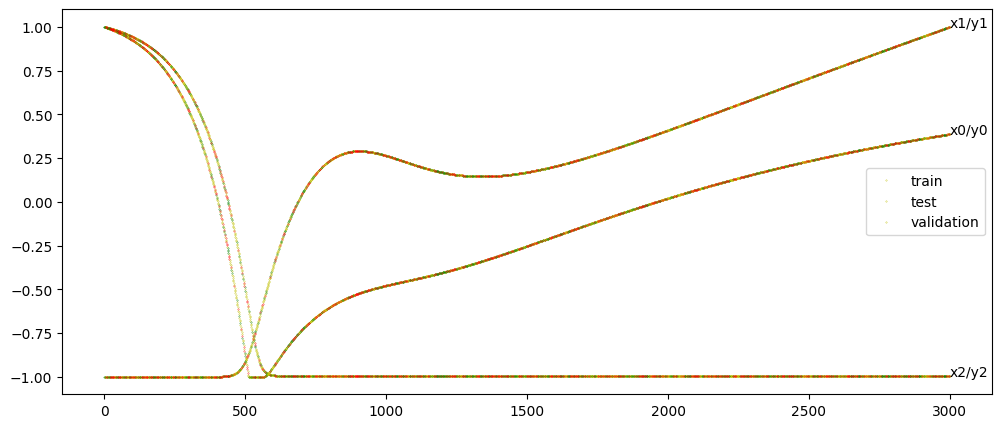

In [6]:
# paths para guardar resultados
fig_path = "figures"
if not os.path.exists(fig_path): os.makedirs(fig_path)

csv_path = "resultados"
if not os.path.exists(csv_path): os.makedirs(csv_path)

# cargar archivo

## load data
data_path='/content/Introduction-to-IA/neural_networks/mlp_data/bacterial_growth_extended.txt'
np.random.seed(2)
X,Y_d,X_test,Y_d_test,X_val,Y_d_val=load_data(data_path,fig_path,autoencoder=True)

# inicializar dfs para guardar resultados
model_label_info=['layers', 'neurons', 'eta']
error=pd.DataFrame(columns=model_label_info).set_index(model_label_info)
energia_error=pd.DataFrame();
my_index = pd.MultiIndex(levels=[[]]*5,codes=[[]]*5,names=['layer','L','li','eta','neuron'])
deltas=pd.DataFrame(index=[],columns=my_index)
avrg_delta=pd.DataFrame(index=[],columns=my_index.droplevel(-1))
predictions=pd.DataFrame(columns=model_label_info).set_index(model_label_info)
w_vals=pd.DataFrame(columns=model_label_info).set_index(model_label_info)
val_predictions=pd.DataFrame(columns=model_label_info).set_index(model_label_info)

In [9]:
# activation functions and their derivatives
phi_t=lambda x,k: (np.exp(k*x)-np.exp(-k*x))/(np.exp(k*x)+np.exp(-k*x)) # tanh
diff_phi_t=lambda x,k: 1-phi_t(x,k)**2
phi_1=lambda x,k: k*x # lineal
diff_phi_1=lambda x,k: np.ones((x.shape[0],x.shape[1]))*k
phi_s=lambda x,k: 1/(1+exp(-k*x)) # sigmoide
diff_pfi_s=lambda x,k: k*exp(-k*x)/(1+exp(-k*x))**2

# Indivually train an MLP

In [ ]:
'''
# setup
L=1;mj=10
epocas=50; eta=0.9; tol=10**-3
bias=dict([(key,0) for key in range(L+1)])
layers_setup=lambda L,mj,m: [(mj,phi_t,diff_phi_t)]*L+[(m,phi_t,diff_phi_t)]

# run exp
start=time.time()
n=len(X[0]); m=len(Y_d[0])
dfs=[predictions,w_vals,energia_error,error,deltas,avrg_delta]

## init model
model_label=('L_tlt=%i'%L,'$l_i$=%i'%mj,'$eta=%.2f$'%eta)
model = MLP(layers_setup(L,mj,m),X.T,bias)# init model on random sol

## descenso por el gradiente
local_grads,avrg_errors,grad_dead_at=grad_descent(X,Y_d,model,epocas=epocas,eta=eta,tol=tol)
# guardar informacion del entrenamiento
dfs=process_exp(model_label,model,local_grads,avrg_errors,grad_dead_at, n,m,L,start,X_test,Y_d_test,dfs,csv_path)
predictions,w_vals,energia_error,error,deltas,avrg_delta=dfs

# plot all
model_names=error.index.to_list()
figs=['']*len(model_names)

## plot outputs
graficar_Y(Y_d_test,predictions,figs,model_names,
        "test dataset: real output vs. MLP output",fig_path+'/outputs.png')
## errors
display(error.loc[model_names].sort_index())
'''

'\n# setup\nL=1;mj=10\nepocas=50; eta=0.9; tol=10**-3\nbias=dict([(key,0) for key in range(L+1)])\nlayers_setup=lambda L,mj,m: [(mj,phi_t,diff_phi_t)]*L+[(m,phi_t,diff_phi_t)]\n\n# run exp\nstart=time.time()\nn=len(X[0]); m=len(Y_d[0])\ndfs=[predictions,w_vals,energia_error,error,deltas,avrg_delta]\n\n## init model\nmodel_label=(\'L_tlt=%i\'%L,\'$l_i$=%i\'%mj,\'$eta=%.2f$\'%eta)\nmodel = MLP(layers_setup(L,mj,m),X.T,bias)# init model on random sol\n\n## descenso por el gradiente\nlocal_grads,avrg_errors,grad_dead_at=grad_descent(X,Y_d,model,epocas=epocas,eta=eta,tol=tol)\n# guardar informacion del entrenamiento\ndfs=process_exp(model_label,model,local_grads,avrg_errors,grad_dead_at, n,m,L,start,X_test,Y_d_test,dfs,csv_path)\npredictions,w_vals,energia_error,error,deltas,avrg_delta=dfs\n\n# plot all\nmodel_names=error.index.to_list()\nfigs=[\'\']*len(model_names)\n\n## plot outputs\ngraficar_Y(Y_d_test,predictions,figs,model_names,\n        "test dataset: real output vs. MLP output",fig

# correr experimentos para calibrar hyperparametros

running  L=1 eta=0.90


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 38


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 32


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 26


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 12


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 16


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 15


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 11
running  L=1 eta=0.50


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 50


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 42


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 38


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 22


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 21


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 18


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 16
running  L=1 eta=0.20


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 80


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 79


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 66


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 31


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 27


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 25


  0%|          | 0/200 [00:00<?, ?it/s]

gradients died first at iteration 23


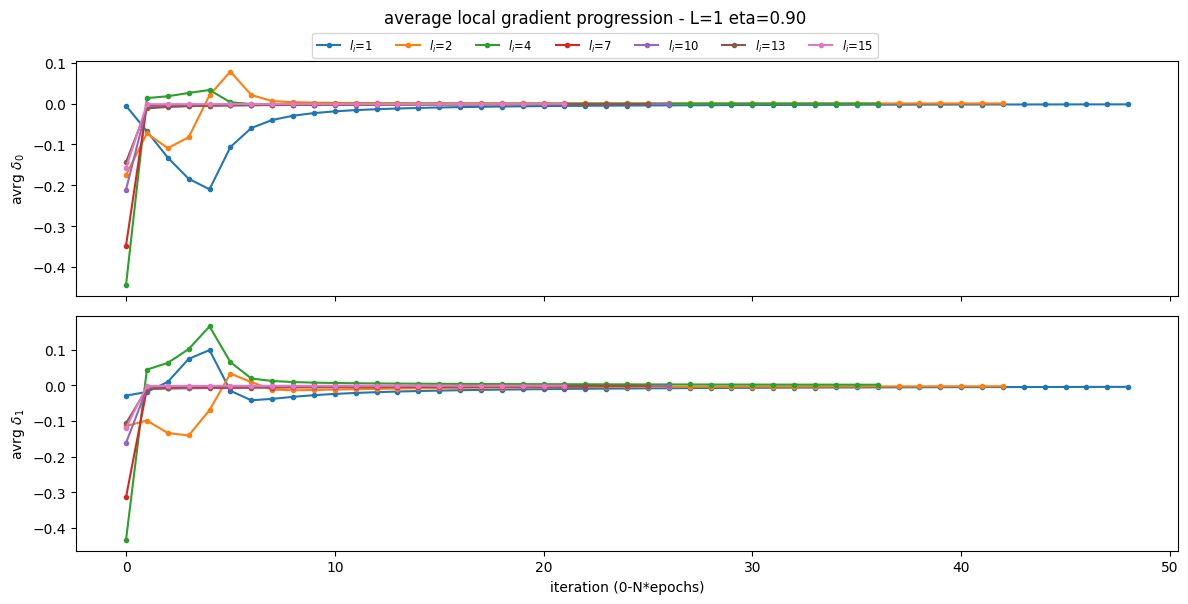

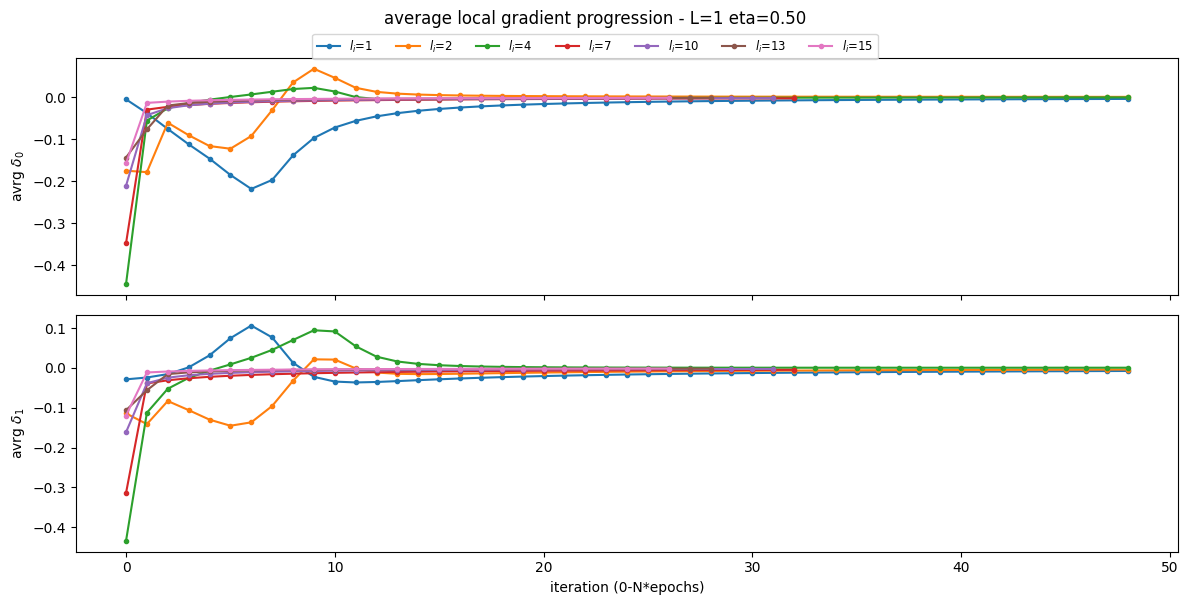

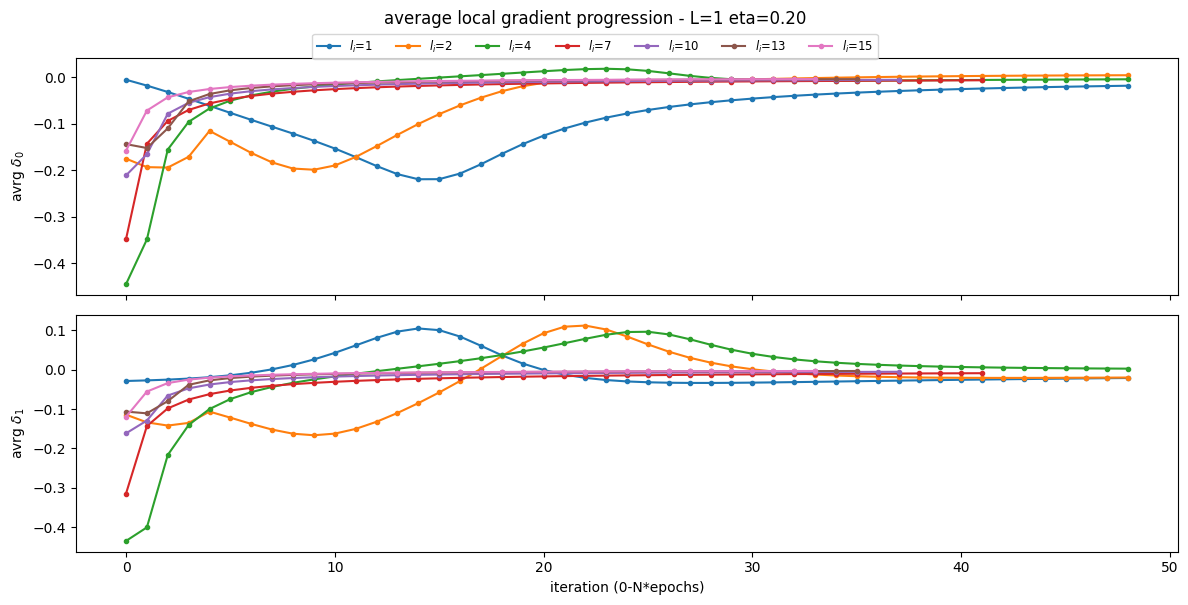

In [10]:
# setup experiment
epocas=100; tol=10**-3
n=len(X[0]); m=len(Y_d[0])

# setup activations
layers_setup=lambda L,mj,m: [(mj,phi_t,diff_phi_t)]*L+[(m,phi_t,diff_phi_t)]
dfs=[predictions,w_vals,energia_error,error,deltas,avrg_delta]


for L in [1]: # number of hidden layers

    # set up bias for each layer
    bias=dict([(key,-0.3) for key in range(L)]+[(L,0)])

    for eta in [0.9,0.5,0.2]: # learning rate

        # experiment identifier
        exp_name="L=%i eta=%.2f"%(L,eta)
        print('running ',exp_name)

        for mj in [1,2,4,7,10,13,15]: # number of neurons on hidden layer

            # model identifier and start of training time
            model_label=('L=%i'%L, '$l_i$=%i'%mj,'$eta=%.2f$'%eta)
            start=time.time()

            # initialize model on random weights
            model = MLP(layers_setup(L,mj,m),X.T,bias)

            # gradient descent
            local_grads,avrg_error,grad_dead_at=grad_descent(X,Y_d,model,epocas=epocas,eta=eta,tol=tol)

            # store model training information
            dfs=process_exp(model_label,model, local_grads,avrg_error,grad_dead_at,n,m,L,start,X_test,Y_d_test,dfs,csv_path)

        # visualize each experiment: grouped by number of layers and learning rate
        # define grouping
        args_exp={'key':("L=%i"%L,'$eta=%.2f$'%eta), 'level':[1,3],'axis':1}

        # unpack avrg_delta from information dfs
        avrg_delta=dfs[-1]

        # build figures
        graficar_df(avrg_delta.xs(**args_exp),'v',lambda i: "avrg $\\delta_%s$"%i,
                    'iteration (0-N*epochs)',"average local gradient progression - %s"%exp_name,
                    rot=0,figsize=(12,6),name='fig_avrg_delta_%s'%exp_name.replace(" ", "_"),path=fig_path)

# unpack experimentation information
predictions,w_vals,energia_error,error,deltas,avrg_delta=dfs

# visualizaciones adicionales

,,,train error,test error,time [s],$\delta_0$,$\delta_1$,gradient death i
layers,neurons,eta,,,,,,
L=1,$l_i$=4,$eta=0.90$,0.374512,0.244333,0.779971,-0.000153,0.002232,26.0


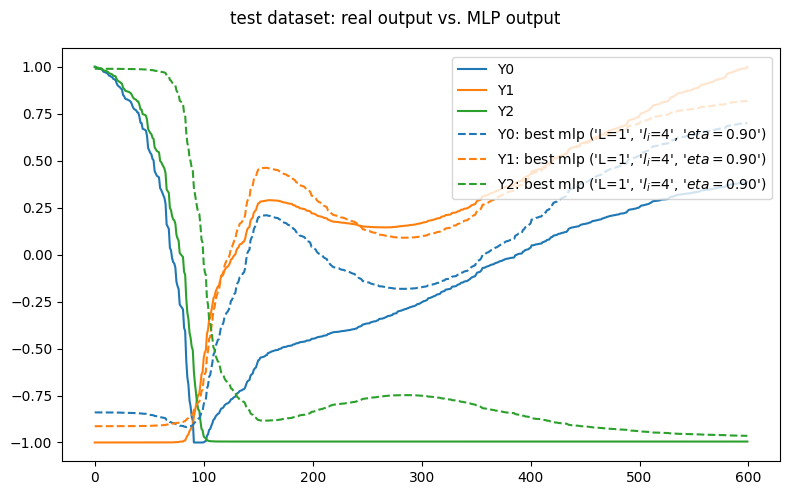

In [11]:
# pick model with lowest test error
criteria=["test error"]
model_names=[error[error[criteria]==error[criteria].min()].dropna(how='all').index[0]]

# model description on figure
model_desc=['best mlp']

# plot all models
#model_names=error.index.to_list(); model_desc=['']*len(model_names)

## plot outputs
graficar_Y(Y_d_test,predictions,model_desc,model_names,
           "test dataset: real output vs. MLP output",fig_path+'/test_outputs.png')
## errors
display(error.loc[model_names].sort_index())

,,,train error,test error,time [s],$\delta_0$,$\delta_1$,gradient death i
layers,neurons,eta,,,,,,
L=1,$l_i$=2,$eta=0.50$,2.615209,3.256494,0.504782,0.00051,-0.004299,42.0


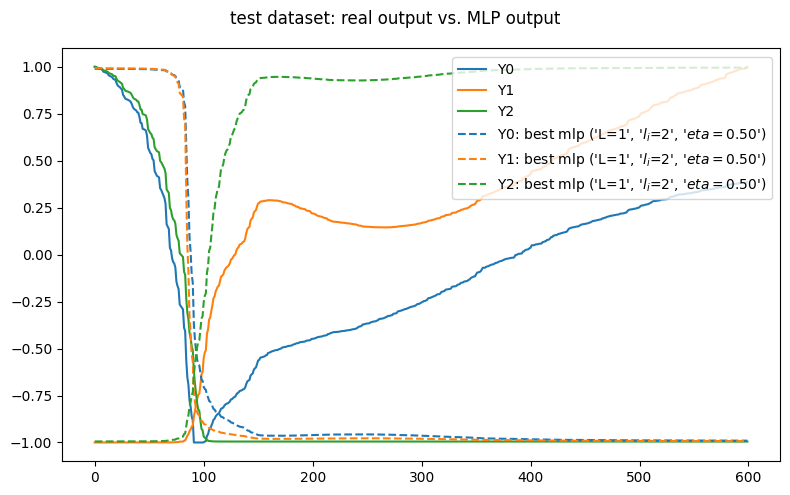

In [12]:
# pick compression model with lowest test error
criteria=["test error"]
compression_models_error=pd.concat([error.xs(("$l_i$=1"), level=1), error.xs(("$l_i$=2"), level=1)])
model_names=[error[error[criteria]==compression_models_error[criteria].min()].dropna(how='all').index[0]]

# model description on figure
model_desc=['best mlp']

## plot outputs
graficar_Y(Y_d_test,predictions,model_desc,model_names,
           "test dataset: real output vs. MLP output",fig_path+'/test_outputs.png')
## errors
display(error.loc[model_names].sort_index())

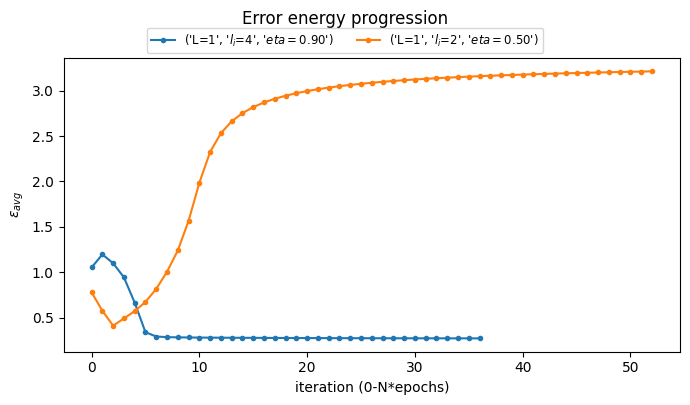

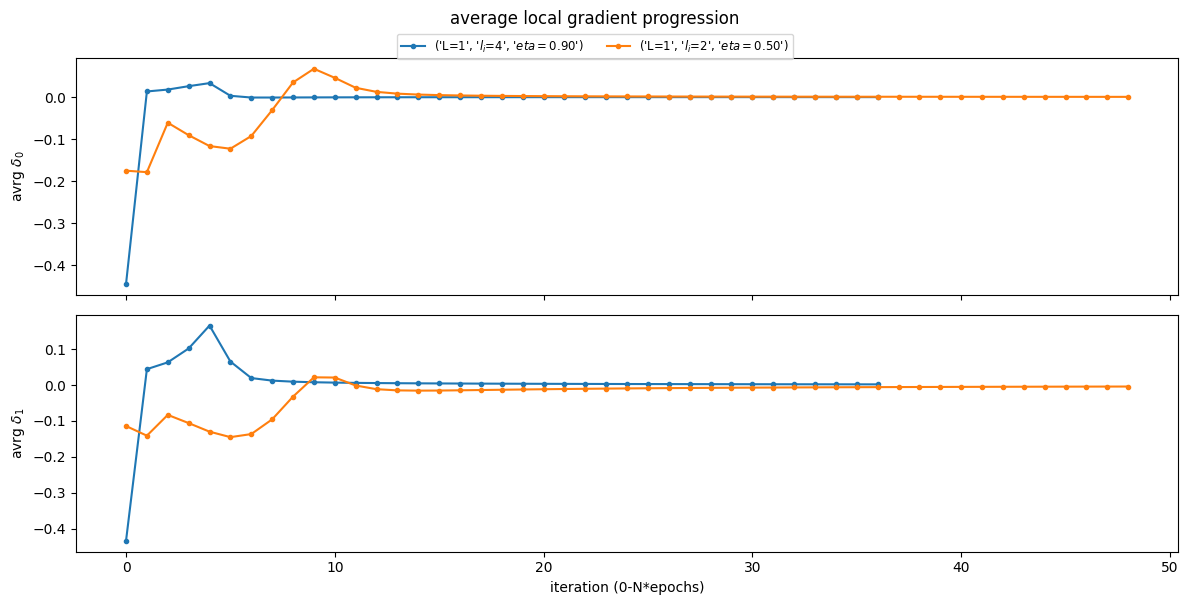

In [13]:
# select best compresion and expansion models
criteria=["test error"]
model_names=[error[error[criteria]==error[criteria].min()].dropna(how='all').index[0],
             error[error[criteria]==compression_models_error[criteria].min()].dropna(how='all').index[0]]

# plot error energy progession during training
filter=[x[1:] in model_names for x in energia_error.columns]
graficar_df(energia_error.loc[:,filter],'v',lambda i: "$\\varepsilon_{avg}$",
            'iteration (0-N*epochs)',"Error energy progression",rot=0,
            name='error_energy',path=fig_path)

# plot average local gradients progression during training
filter=[x[1:] in model_names for x in avrg_delta.columns]
graficar_df(avrg_delta.loc[:,filter],'v',lambda i: "avrg $\\delta_%s$"%i,
            'iteration (0-N*epochs)',"average local gradient progression",
            rot=0,figsize=(12,6),name='avrg_delta',path=fig_path)

train error  test error  time [s]  $\delta_0$  \
layers neurons eta                                                         
L=1    $l_i$=2 $eta=0.50$     2.615209    3.256494  0.504782    0.000510   
       $l_i$=4 $eta=0.90$     0.374512    0.244333  0.779971   -0.000153   

                           $\delta_1$  gradient death i  val error  
layers neurons eta                                                  
L=1    $l_i$=2 $eta=0.50$   -0.004299              42.0   0.794752  
       $l_i$=4 $eta=0.90$    0.002232              26.0   1.066622

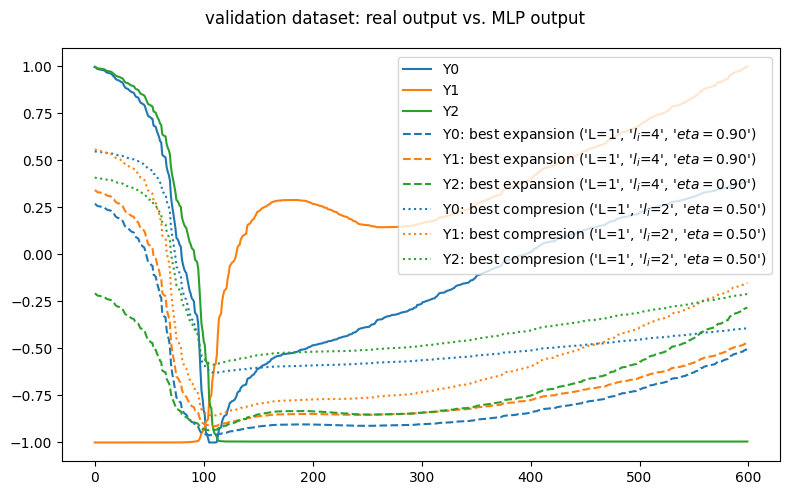

In [17]:
# validation error

# recreate each selected model and load trained weights
for i, model_label in enumerate(model_names):

  # init model on random W values
  L=int(model_label[0][-1]); mj=int(model_label[1][-1])
  model = MLP(layers_setup(L,mj,m),X_val.T,bias)

  # set W values to selected solution
  for layer,w in w_vals.loc[model_label].items():
    model.w_dict_update(layer,json.loads(w)-model.w_dict[layer])

  # energy error
  energia=np.apply_along_axis(lambda x: np.matmul(x,x)/2, 1, Y_d_val-model.Y.T)
  val_error=np.mean(energia,axis=0,keepdims=True)

  # save results
  error.loc[model_label,'val error']=val_error

  # plot predictions on validation dataset
  Y_pred_dict=dict(zip(range(m),model.Y))
  for output,y_pred in Y_pred_dict.items():
      val_predictions.at[model_label,output]=str(y_pred.tolist())


## plot outputs
model_desc=['best expansion','best compresion']
graficar_Y(Y_d_val,val_predictions,model_desc,model_names,
           "validation dataset: real output vs. MLP output",fig_path+'/val_outputs.png')
## errors
display(error.loc[model_names].sort_index())


# Extract coded data at hidden layer

**to train an sklearn MLP**

In [18]:
# find coded outputs of training and test input datasets
cod_data=[[],[]]; cod_test_data=[[],[]]

# recreate each selected model and load trained weights
for i, model_label in enumerate(model_names):

  # init model
  L=int(model_label[0][-1]); mj=int(model_label[1][-1])
  model = MLP(layers_setup(L,mj,m),X.T,bias)

  # set W values to pre-trained weights
  for layer,w in w_vals.loc[model_label].items():
    model.w_dict_update(layer,json.loads(w)-model.w_dict[layer])

  # evaluate on train data
  model.frwd_eval(model.w_dict,X.T)
  # get code at hidden layer output
  cod_data[i]=model.conf[0].Y.T

  # evaluate on test data
  model.frwd_eval(model.w_dict,X_test.T)
  # get code at hidden layer output
  cod_test_data[i]=model.conf[0].Y.T

<ipython-input-2-77e697cdca72>:126: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_train=File_data[set(col_x+col_y)].loc[ix[:n_train]]
<ipython-input-2-77e697cdca72>:127: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_test=File_data[set(col_x+col_y)].loc[ix[n_train:n_train+n_test]].sort_index()
<ipython-input-2-77e697cdca72>:128: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_val=File_data[set(col_x+col_y)].loc[ix[-n_val:]].sort_index()


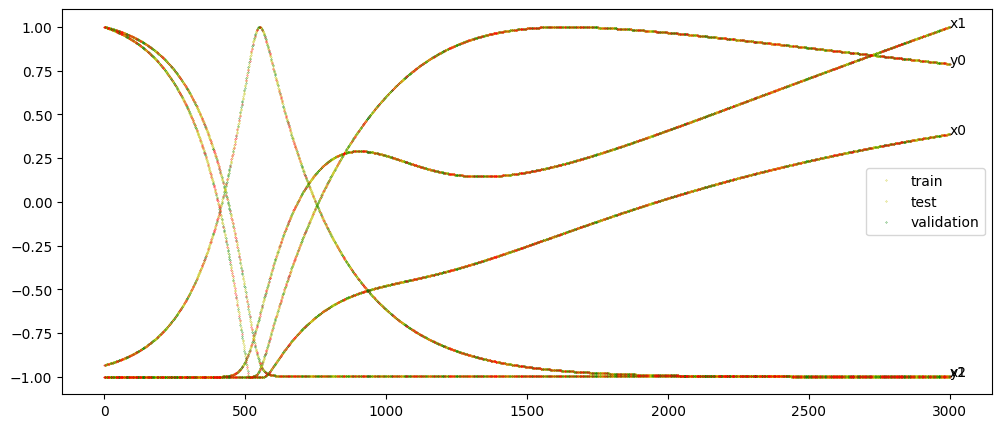

In [19]:
# set original output data
_,Y_d,_,Y_d_test,_,Y_d_val=load_data(data_path,fig_path,autoencoder=False)

# define new input data: expanded and compresed inputs
expanded_X=cod_data[0]; compressed_X=cod_data[1]
expanded_X_test=cod_test_data[0]; compressed_X_test=cod_test_data[1]

In [30]:
# initialize mlp class
from sklearn.neural_network import MLPRegressor

def mlp_codedInput(X,Y_d,X_test,Y_d_test,model_names):
  mlp_model = MLPRegressor()

  # train MLP on expanded data
  mlp_model.fit(X, Y_d)
  # show loss progression through trainning
  plt.plot(mlp_model.loss_curve_)
  plt.xlabel('training iteration'); plt.title("Error progression")
  plt.savefig(fig_path+'/sklearn_mlp_error_%s.png'%model_names[0])

  # store training error
  error=[np.sum((Y_d-mlp_model.predict(X))**2/2,axis=1)]

  # predict test data
  Y_pred=mlp_model.predict(X_test)

  # store test error
  error.append(np.sum((Y_d_test-Y_pred)**2/2,axis=1))

  # plot prediction on test dataset
  model_desc=['sklearn_mlp']
  predictions=pd.DataFrame([str(x.tolist()) for x in Y_pred.T],index=list(range(len(Y_pred[0]))),columns=model_names).T
  graficar_Y(Y_d_test,predictions,model_desc,model_names,
            "test dataset: real output vs. sklearn MLP output",fig_path+'/sklearn_test_outputs_%s.png'%model_names[0])

  # R2 score
  r2_error=[mlp_model.score(x, y)**2/2 for x,y in zip([X,X_test],[Y_d,Y_d_test])]
  # error
  J_error=[np.mean(x) for x in error]
  J_error_df=pd.DataFrame(J_error,index=['train error','test_error'],columns=['sklearn_MLP '+model_names[0]]).T
  return J_error_df

,train error,test_error
sklearn_MLP on expanded data,0.402245,0.466924


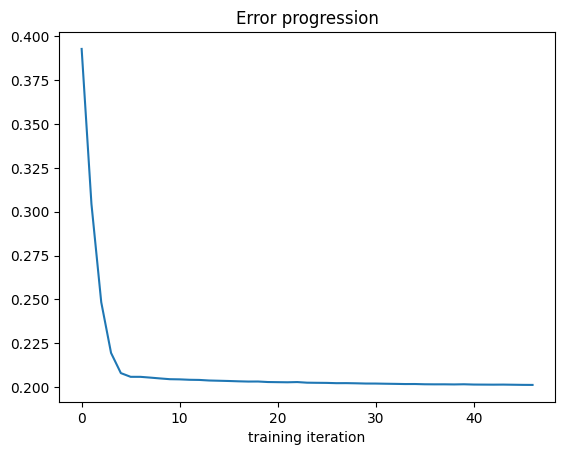

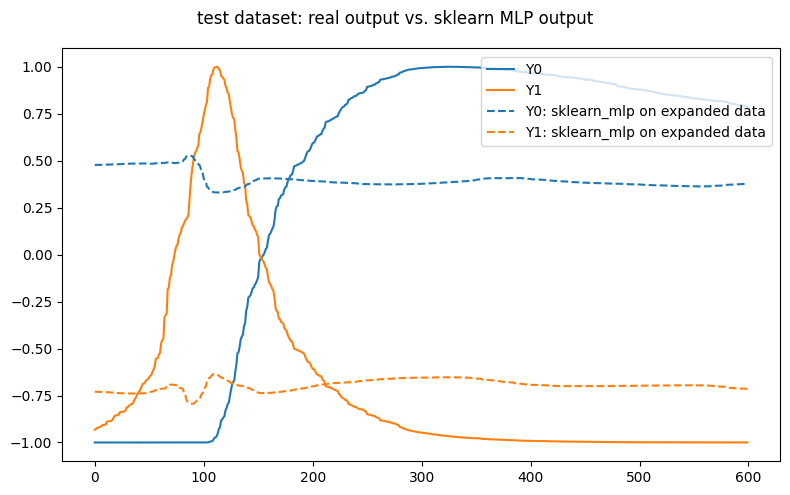

In [31]:
error = mlp_codedInput(expanded_X,Y_d,expanded_X_test,Y_d_test,['on expanded data'])
error

,train error,test_error
sklearn_MLP on compresed data,0.402778,0.46129


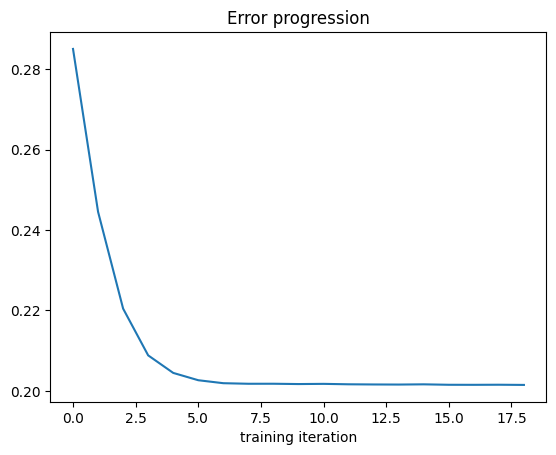

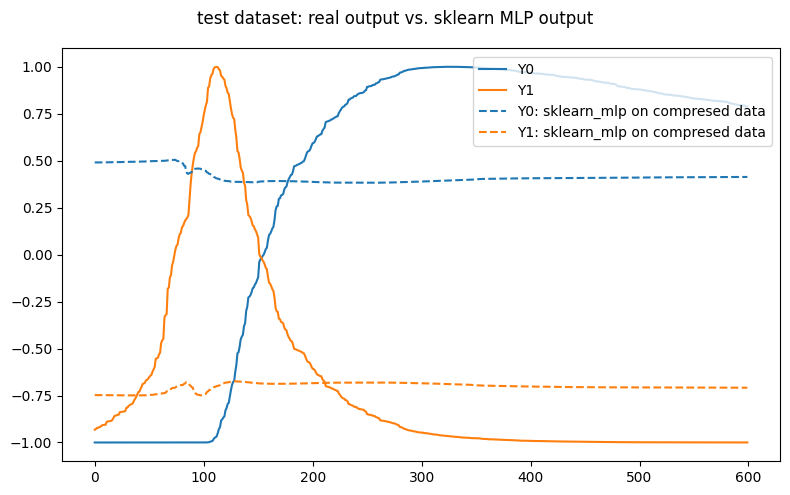

In [32]:
error = mlp_codedInput(compressed_X,Y_d,compressed_X_test,Y_d_test,['on compresed data'])
error

,train error,test_error
sklearn_MLP on original data,0.402568,0.467047


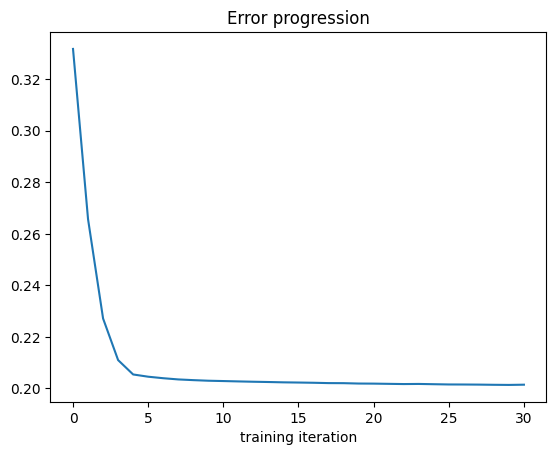

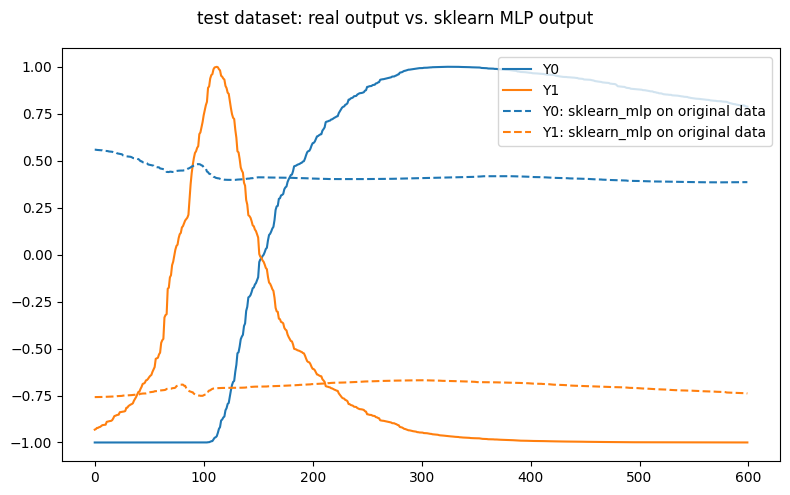

In [33]:
error = mlp_codedInput(X,Y_d,X_test,Y_d_test,['on original data'])
error